In [1]:
import qiskit
from qiskit import QuantumCircuit, Aer, execute
import numpy as np
import math
from scipy.linalg import lapack
from src.rdmg import rdm_ginibre
import sys
from qiskit import QuantumRegister,ClassicalRegister,QuantumCircuit


In [2]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt

from qiskit.extensions import RXGate, XGate, CXGate

In [3]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


/tmp/ipykernel_85450/4168623211.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [81]:
qiskit.IBMQ.save_account('2537d4125e263262381a269464d18da5d1d1a37a4a00534ce31274e9e2186327f9f93c3cf4265d538d599408669cf7ebe06b299ead2876a3035550c0071af3b6', overwrite=True)

In [4]:
from qiskit import *
nshots = 8192
#nshots = 10000
IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q', group='open', project='main')
#provider = qiskit.IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_quito')
#device = provider.get_backend('ibm_nairobi')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [5]:
from qiskit.tools.monitor import backend_overview, backend_monitor
backend_overview()

ibm_perth                    ibm_nairobi                  ibm_lagos
---------                    -----------                  ---------
Num. Qubits:  7              Num. Qubits:  7              Num. Qubits:  7
Pending Jobs: 38             Pending Jobs: 27             Pending Jobs: 35
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      191.2          Avg. T1:      115.0          Avg. T1:      107.4
Avg. T2:      122.6          Avg. T2:      49.5           Avg. T2:      65.1



ibmq_manila                  ibmq_jakarta                 ibmq_quito
-----------                  ------------                 ----------
Num. Qubits:  5              Num. Qubits:  7              Num. Qubits:  5
Pending Jobs: 5              Pending Jobs: 27             Pending Jobs: 33
Least busy:   True           Least busy:   False          Least busy:   False
Operational:  True           Operatio

In [6]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

In [7]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute, Aer
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix

In [ ]:
# define a função rdm_ginibre
#def rdm_ginibre(dim):
    # código para rdm_ginibre

# define as funções get_abs_lambda e get_rho_circuit
#def get_abs_lambda(rho):
    # código para get_abs_lambda

#def get_rho_circuit(psi, rho, u):
    # código para get_rho_circuit


In [49]:
def filtro(valor):
    if abs(valor) < 0.00000001:
        return 0
    else:
        return valor

def get_abs_lambda(rho):

    n = np.shape(rho)[0]
    w, u, _ = lapack.zheev(rho, overwrite_a=True)
    psi = 0
    for i in range(len(u)):
        u[:, i] = u[:, i]/np.linalg.norm(u[:, i])
    for i in range(n):
        #rho += w[i] * np.outer(u[:, i], u[:, i].conj()) # se precisar do rho
        w[i] = filtro(w[i])
        print(f'w[{i}] = ', w[i])
        if w[i] < 0.0000001:
            w[i] == 0
        psi += math.sqrt(w[i])*np.eye(n)[:, i]
    return psi, u


In [9]:
def get_rho_circuit(psi, rho, u):
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    #print(n_qubits)

    qr = QuantumRegister(d)
    #cr = ClassicalRegister(n_qubits)
    if n_qubits == 1:
        lista = [qr[0]]
    else:
        lista = []
        for i in range(n_qubits):
            #lista = [i for i in qr]#[:-1]#[,qr[1]]
            lista.append(qr[i])
    U_op = Operator(u)
    qc = QuantumCircuit(qr, name='qc_initialize')

    qc.initialize(psi, lista)
    for i in range(int(n_qubits)):
        qc.cx(i, int(n_qubits)+i)
    qc.append(U_op,   list(range(n_qubits)))
            
    return qc





In [10]:
def Psi00(th):
    return np.array([[np.cos(th)],[0],[0],[np.sin(th)]]);

def Psi01(ph):
    return np.array([[0],[np.sin(ph)],[np.cos(ph)],[0]]);

def Psi11(ph):
    return np.array([[0],[np.cos(ph)],[-np.sin(ph)],[0]]);

def Psi10(th):
    return np.array([[-np.sin(th)],[0],[0],[np.cos(th)]]);

In [14]:
th=np.pi/4
ph=np.pi/4

def rhoX(th,ph,p00,p01,p10,p11):
    return p00*(Psi00(th)*Psi00(th).T) +  p01*(Psi01(ph)*Psi01(ph).T) + p10*(Psi10(th)*Psi10(th).T) + p11*(Psi11(ph)*Psi11(ph).T)

rhoX(th,ph,1/2,1/2,0,0)

array([[0.25, 0.  , 0.  , 0.25],
       [0.  , 0.25, 0.25, 0.  ],
       [0.  , 0.25, 0.25, 0.  ],
       [0.25, 0.  , 0.  , 0.25]])

In [22]:
###Teste implementação/simulação estado tipo X escolhido 

rhoX_ = np.array(rhoX(np.pi/4,np.pi/4,1/2,0,0,1/2))
n_qubits = int(np.ceil(np.log2(np.shape(rhoX_)[0])))
d = int(2*n_qubits)
qr = QuantumRegister(d)
qc = QuantumCircuit(qr)
psi, u = get_abs_lambda(rhoX_)
qc_ = get_rho_circuit(psi, rhoX_, u)
qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # [qr[0],qr[1]]circuito para TEQ
job_sim = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots = nshots)
print(job_sim.job_id()); job_monitor(job_sim)
qstf = StateTomographyFitter(job_sim.result(), qstc) # ajusta os dados
rhofit = qstf.fit(method='lstsq'); #extrai o operador densidade
fid = state_fidelity(rhoX_, rhofit); #fidelidade entre estado tomografado e rhogerado aleatóriamente
print(rhofit)
print(fid)

4d9d164e-4784-45e2-8b52-e92e614104f1

Job Status: job has successfully run
[[ 0.33470654+0.j         -0.00150173+0.00104965j -0.00068527+0.00405615j
  -0.00191547-0.00023502j]
 [-0.00150173-0.00104965j  0.17319915+0.j          0.16865599-0.00198235j
   0.0032019 -0.00409727j]
 [-0.00068527-0.00405615j  0.16865599+0.00198235j  0.16519481+0.j
   0.00196766-0.00299956j]
 [-0.00191547+0.00023502j  0.0032019 +0.00409727j  0.00196766+0.00299956j
   0.3268995 +0.j        ]]
0.9993243776825116


In [43]:
###Teste implementação/simulação estado tipo X escolhido 
import numpy as np
from numpy import zeros, conjugate, sqrt
def eVals(A):
    d = A.shape[0]; evals = zeros(d,1)
    eig = A.eigenvects()
    ne = 0
    j = 0
    lk = 0
    while ne < d:
        mult = eig[j][1]
        ne += mult
        nk = lk + mult
        for k in range(lk,nk):
            evals[k] = eig[j][0]
        lk = nk
        j += 1
    return evals

def tp_(x,y):
    return np.kron(x,y)

def coh_l1(rho):
        d = rho.shape[0]
        C = 0
        for j in range(0, d-1):
            for k in range(j+1, d):
                C += abs(rho[j, k])
        return 2 * C

def concurrence(rho):
    pauli = np.array([[0, 1], [1, 0]])
    tp_pauli = np.kron(pauli, pauli)
    rho_conj = np.conjugate(rho)
    
    R = rho.dot(tp_pauli).dot(rho_conj).dot(tp_pauli)
    ev = np.linalg.eigvals(R)
    evm = np.max(np.abs(ev))
    
    C = 2.0 * np.sqrt(np.abs(evm)) - np.sqrt(np.abs(ev[0])) - np.sqrt(np.abs(ev[1])) - np.sqrt(np.abs(ev[2])) - np.sqrt(np.abs(ev[3]))
    C = np.maximum(C, 0.0)
    
    return C

def varredura():
    space = np.linspace(0,np.pi,10)
    conc = []
    coh = []
    for i in space:
        rhoX_ = np.array(rhoX(np.pi/4,i,1/2,0,1/2,0))
        n_qubits = int(np.ceil(np.log2(np.shape(rhoX_)[0])))
        d = int(2*n_qubits)
        qr = QuantumRegister(d)
        qc = QuantumCircuit(qr)
        psi, u = get_abs_lambda(rhoX_)
        qc_ = get_rho_circuit(psi, rhoX_, u)
        qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

        qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # [qr[0],qr[1]]circuito para TEQ
        job_sim = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots = nshots)
        print(job_sim.job_id()); job_monitor(job_sim)
        qstf = StateTomographyFitter(job_sim.result(), qstc) # ajusta os dados
        rhofit = qstf.fit(method='lstsq'); #extrai o operador densidade
        conc.append(concurrence(rhofit))
        coh.append(coh_l1(rhofit))
        fid = state_fidelity(rhoX_, rhofit); #fidelidade entre estado tomografado e rhogerado aleatóriamente
        #print(rhofit)
        #print(fid)
    plt.plot(space, conc)
    plt.plot(space, coh)
    plt.show()
varredura()

0.0
0.0
0.5
0.5


5ed5baa1-1271-4b4f-8913-8378a1ee6046
Job Status: job is being initialized

KeyboardInterrupt: 

w[0] =  0.0
w[1] =  0.0
w[2] =  0.0
w[3] =  1.0
a80ccc1f-7039-488e-bb49-7654082290af
Job Status: job has successfully run
w[0] =  0.0
w[1] =  0.0
w[2] =  0.1111111111111111
w[3] =  0.8888888888888888
5675e63e-69f8-4e5b-b37c-09999fe2100d
Job Status: job has successfully run
w[0] =  0.0
w[1] =  0.0
w[2] =  0.22222222222222218
w[3] =  0.7777777777777778
649b3c63-9f48-425e-b44e-16e5b8b7ebcc
Job Status: job has successfully run
w[0] =  0.0
w[1] =  0.0
w[2] =  0.3333333333333333
w[3] =  0.6666666666666667
63dd2295-5180-43f2-94dc-e962ce925bfb
Job Status: job has successfully run
w[0] =  0.0
w[1] =  0.0
w[2] =  0.4444444444444444
w[3] =  0.5555555555555556
35308913-e96d-4165-bb1c-a1c0c5b8df93
Job Status: job has successfully run
w[0] =  0.0
w[1] =  0.0
w[2] =  0.4444444444444444
w[3] =  0.5555555555555556
49ad59d2-7d6b-410b-b0af-5545eb8503bf
Job Status: job has successfully run
w[0] =  0.0
w[1] =  0.0
w[2] =  0.33333333333333337
w[3] =  0.6666666666666665
f0df0a64-da25-48c3-8df6-529eb33351db
J

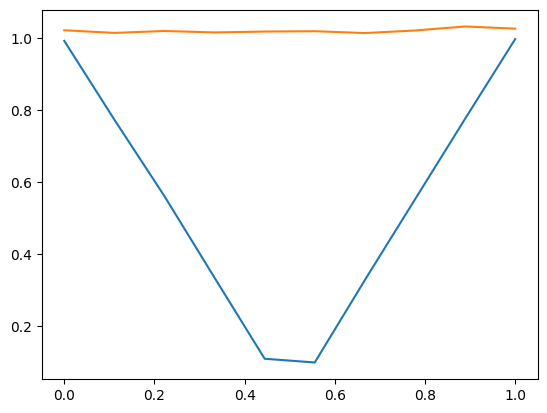

In [50]:
def varredura2():
    space = np.linspace(0,1,10)
    conc = []
    coh = []
    for i in space:
        rhoX_ = np.array(rhoX(np.pi/4,np.pi/4,i,0,0,1-i))
        n_qubits = int(np.ceil(np.log2(np.shape(rhoX_)[0])))
        d = int(2*n_qubits)
        qr = QuantumRegister(d)
        qc = QuantumCircuit(qr)
        psi, u = get_abs_lambda(rhoX_)
        qc_ = get_rho_circuit(psi, rhoX_, u)
        qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

        qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # [qr[0],qr[1]]circuito para TEQ
        job_sim = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots = nshots)
        print(job_sim.job_id()); job_monitor(job_sim)
        qstf = StateTomographyFitter(job_sim.result(), qstc) # ajusta os dados
        rhofit = qstf.fit(method='lstsq'); #extrai o operador densidade
        conc.append(concurrence(rhofit))
        coh.append(coh_l1(rhofit))
        fid = state_fidelity(rhoX_, rhofit); #fidelidade entre estado tomografado e rhogerado aleatóriamente
        #print(rhofit)
        #print(fid)
    plt.plot(space, conc)
    plt.plot(space, coh)
    plt.show()
varredura2()

In [ ]:
def varredura2():
    space = np.linspace(0,1,10)
    conc = []
    coh = []
    for i in space:
        rhoX_ = np.array(rhoX(np.pi/4,np.pi/4,i,0,(1-i)/2,(1-i)/2))
        n_qubits = int(np.ceil(np.log2(np.shape(rhoX_)[0])))
        d = int(2*n_qubits)
        qr = QuantumRegister(d)
        qc = QuantumCircuit(qr)
        psi, u = get_abs_lambda(rhoX_)
        qc_ = get_rho_circuit(psi, rhoX_, u)
        qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

        qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # [qr[0],qr[1]]circuito para TEQ
        job_sim = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots = nshots)
        print(job_sim.job_id()); job_monitor(job_sim)
        qstf = StateTomographyFitter(job_sim.result(), qstc) # ajusta os dados
        rhofit = qstf.fit(method='lstsq'); #extrai o operador densidade
        conc.append(concurrence(rhofit))
        coh.append(coh_l1(rhofit))
        fid = state_fidelity(rhoX_, rhofit); #fidelidade entre estado tomografado e rhogerado aleatóriamente
        #print(rhofit)
        #print(fid)
    plt.plot(space, conc)
    plt.plot(space, coh)
    plt.show()
varredura2()

In [36]:
math.sqrt(-1.1430056960100788e-16)

ValueError: math domain error

In [76]:
rhoX(np.pi/4, np.pi/4, 1, 0, 0, 0)

array([[0.5, 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0.5]])

In [110]:
#Teste implementação/simulação estado tipo X escolhido 
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute, Aer
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix
n_matrices = np.linspace(0, np.pi/4, 10)
coherence_values = []
concurrence_values = []
# Matrix generator
for i, matriz in enumerate(n_matrices):
    # constraints of parameter values
    matriz = np.clip(matriz, 0, np.pi/4)
    # Input state
    rho_xx = rhoX(np.pi/4, matriz, 1/2, 1/4, 1/4,0) 
    # sets the number of qubits 
    n_qubits = int(np.ceil(np.log2(np.shape(rho_xx)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # create quantum circuit
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho_xx)
    qc_ = get_rho_circuit(psi, rho_xx, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])
    # tomo circuit
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
    job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots = nshots)
    print(job_sim.job_id())
    job_monitor(job_sim)

    # fit
    qstf = StateTomographyFitter(job_sim.result(), qstc)
    
    # Density Operator fit
    rho_fit = qstf.fit(method='lstsq')
    print("Matriz {}:".format(i+1))
    print(rho_fit)
    
    # Fidelity
    fid = state_fidelity(rho_xx, rho_fit)
    print("Fidelity: {}".format(fid))
    
    # L1 norm Coherence of rho_fit
    coherence_l1 = coh_l1(rho_fit)
    print("L1 Coherence: {}".format(coherence_l1))
    
    # Entanglement concurrence of rho_fit
    concurrence_ = concurrence(rho_fit)
    print("Concurrence: {}".format(concurrence_))
    
    # Storage of values of Coh and Conc
    coherence_values.append(coherence_l1)
    concurrence_values.append(concurrence_)

ea0a75fd-2d91-4ffc-9eff-c75f1b7a8499
Job Status: job has successfully run
Matriz 1:
[[ 3.74598437e-01+0.j         -6.87188152e-03-0.00216965j
   3.71046818e-04+0.00425971j  1.27262120e-01+0.00826177j]
 [-6.87188152e-03+0.00216965j  2.29226805e-04+0.j
  -2.12658897e-03-0.00150863j  2.09302159e-03-0.00064319j]
 [ 3.71046818e-04-0.00425971j -2.12658897e-03+0.00150863j
   2.53681752e-01+0.j          2.64933653e-03+0.00284853j]
 [ 1.27262120e-01-0.00826177j  2.09302159e-03+0.00064319j
   2.64933653e-03-0.00284853j  3.71490585e-01+0.j        ]]
Fidelity: 0.9995816622320244
L1 Coherence: 0.2953984332309429
Concurrence: 0.2500542897926912
7910a3da-27e2-4c24-bdfb-f8f6bfa25b53
Job Status: job has successfully run
Matriz 2:
[[ 0.37820973+0.j          0.00582883+0.00076539j -0.00258088-0.0036935j
   0.12753066+0.00180555j]
 [ 0.00582883-0.00076539j  0.0025599 +0.j          0.01742305-0.00067252j
   0.00497812+0.00029198j]
 [-0.00258088+0.0036935j   0.01742305+0.00067252j  0.24354761+0.j
  -0.00422

ValueError: math domain error

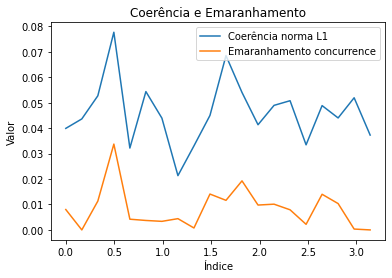

In [93]:

# Plotar os gráficos de coerência e emaranhamento
plt.plot(n_matrices, coherence_values, label='Coerência norma L1')
plt.plot(n_matrices, concurrence_values, label='Emaranhamento concurrence')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Coerência e Emaranhamento')
plt.legend()
plt.show()
#plt.savefig("CohXEnt.pdf")


In [ ]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute, Aer
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix


n_matrices = np.linspace(0, np.pi, 10)

# loop para gerar as matrizes
for i, matriz in enumerate(n_matrices):
    # Limitar o valor da matriz entre 0 e np.pi
    matriz = np.clip(matriz, 0, np.pi)

    # Restante do código dentro do loop
    # Exemplo: imprimir o valor de i e a matriz correspondente
    print(f"Índice: {i}")
    print(f"Matriz: {matriz}")
    # Adicione o restante do seu código aqui
    rho_xx = rhoX(np.pi/4, matriz, 1/2, 0, 1/2, 0)
    
    # calcular a função de coerência norma L1
    def coh_l1(rho):
        d = rho.shape[0]
        C = 0
        for j in range(0, d-1):
            for k in range(j+1, d):
                C += abs(rho[j, k])
        return 2 * C
    
    # calcular a coerência norma L1 para a matriz rho_xx
    coherence_l1 = coh_l1(rho_xx)
    print("Coerência norma L1: {}".format(coherence_l1))
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho_xx)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho_xx)
    qc_ = get_rho_circuit(psi, rho_xx, u)
    qc.append(qc_, [qr[0], qr[1], qr[2], qr[3]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0], qr[1]])

    # executar os circuitos de tomografia
    job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    print(job_sim.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_sim)

    # ajustar os dados
    qstf = StateTomographyFitter(job_sim.result(), qstc)
    
    # extrair o operador densidade
    rho_fit = qstf.fit(method='lstsq')
    print("Matriz {}:".format(i+1))
    print(rho_fit)
    
    # calcular a fidelidade
    fid = state_fidelity(rho_xx, rho_fit)
    print("Fidelidade: {}".format(fid))


In [11]:

rho = rdm_ginibre(4)
n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
d = int(2*n_qubits)
qr = QuantumRegister(d)
qc = QuantumCircuit(qr)
psi, u = get_abs_lambda(rho)
qc_ = get_rho_circuit(psi, rho, u)
qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # [qr[0],qr[1]]circuito para TEQ
job_sim = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots = nshots)
print(job_sim.job_id()); job_monitor(job_sim)
qstf = StateTomographyFitter(job_sim.result(), qstc) # ajusta os dados
rhoDCBA = qstf.fit(method='lstsq'); #extrai o operador densidade
fid = state_fidelity(rho, rhoDCBA); #fidelidade entre estado tomografado e rhogerado aleatóriamente
print(rhoDCBA)
print(fid)

4c24a4ea-87c8-422d-a57b-bf058dac62b5

Job Status: job has successfully run
[[ 0.3302177 +0.j          0.06353486-0.15584915j  0.11616907-0.16669869j
  -0.0225625 +0.17065905j]
 [ 0.06353486+0.15584915j  0.15674479+0.j          0.16413821+0.00496794j
  -0.10830945+0.07274035j]
 [ 0.11616907+0.16669869j  0.16413821-0.00496794j  0.30358168+0.j
  -0.07547444+0.09001674j]
 [-0.0225625 -0.17065905j -0.10830945-0.07274035j -0.07547444-0.09001674j
   0.20945583+0.j        ]]
0.9996134699502809


In [12]:
job_exp = qiskit.execute(qstc, backend = device, shots = nshots)
print(job_exp.job_id())
job_monitor(job_exp)
qstf = StateTomographyFitter(job_exp.result(), qstc) # ajusta os dados
rho_exp = qstf.fit(method='lstsq'); #extrai o operador densidade
fid = state_fidelity(rho, rho_exp); #fidelidade entre estado tomografado e rhogerado aleatóriamente
#print(rho_exp)
print(fid)

chodoitaqbbvbu7bd8r0
Job Status: job has successfully run
0.9801895656439803


In [13]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute, Aer
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix


# definir o número de matrizes a serem geradas
n_matrices = 10

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(4)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])

    # executar os circuitos de tomografia
    job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots = nshots)
    print(job_sim.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_sim)

    # ajustar os dados
    qstf = StateTomographyFitter(job_sim.result(), qstc)
    
    # extrair o operador densidade
    rhoDCBA = qstf.fit(method='lstsq')
    print("Matriz {}:".format(i+1))
    print(rhoDCBA)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rhoDCBA)
    print("Fidelidade: {}".format(fid))
    


29f3e017-6a9a-44c0-baa5-2a355577dcb5
Job Status: job has successfully run
Matriz 1:
[[ 0.12950611+0.j          0.07092244-0.06231391j  0.13124412+0.09909121j
  -0.11010342-0.02244151j]
 [ 0.07092244+0.06231391j  0.17319815+0.j          0.11952727+0.16354033j
  -0.07915709+0.07273012j]
 [ 0.13124412-0.09909121j  0.11952727-0.16354033j  0.37847872+0.j
  -0.10480859+0.15829095j]
 [-0.11010342+0.02244151j -0.07915709-0.07273012j -0.10480859-0.15829095j
   0.31881702+0.j        ]]
Fidelidade: 0.9992227809993741
b8229e37-0d8c-4a6d-8f77-4d63c83d8186
Job Status: job has successfully run
Matriz 2:
[[ 0.14127204+0.j         -0.02409802+0.05474723j -0.08040668+0.13150368j
   0.00986963+0.03764895j]
 [-0.02409802-0.05474723j  0.19213525+0.j          0.0635055 -0.021887j
  -0.06836193-0.13307546j]
 [-0.08040668-0.13150368j  0.0635055 +0.021887j    0.21781455+0.j
   0.11405111-0.03346362j]
 [ 0.00986963-0.03764895j -0.06836193+0.13307546j  0.11405111+0.03346362j
   0.44877816+0.j        ]]
Fidelidad

In [14]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute, Aer
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix


# definir o número de matrizes a serem geradas
n_matrices = 10

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(4)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])

    # executar os circuitos de tomografia
    
    job_exp = qiskit.execute(qstc, backend = device, shots = nshots)
    
    print(job_exp.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_exp)

    # ajustar os dados
    qstf = StateTomographyFitter(job_exp.result(), qstc)
    
    # extrair o operador densidade
    rho_exp = qstf.fit(method='lstsq')
    #print("Matriz {}:".format(i+1))
    #print(rho_exp)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rho_exp)
    print("Fidelidade: {}".format(fid))

chof8touhh1ldcori64g
Job Status: job has successfully run
Fidelidade: 0.9605039303232086
chofh478rmtc64qiug10
Job Status: job has successfully run
Fidelidade: 0.9828244724125228
chofu8v8rmtc64qj5nqg
Job Status: job has successfully run
Fidelidade: 0.9703311685235645
chog8v78rmtc64qjbqfg
Job Status: job has successfully run
Fidelidade: 0.981033742898944
chogka8uhh1ldcosbi0g
Job Status: job has successfully run
Fidelidade: 0.9484566129772233
choh2vlaqbbvbu7dpb10
Job Status: job has successfully run
Fidelidade: 0.9817921908869397
chohdvk2b9sdqn29l8e0
Job Status: job has successfully run
Fidelidade: 0.9865893287629989
chohpktaqbbvbu7ecto0
Job Status: job has successfully run
Fidelidade: 0.9528049018285335
choi2b42b9sdqn2a7jc0
Job Status: job has successfully run
Fidelidade: 0.9663430747543382
choiai0uhh1ldcots3ig
Job Status: job has successfully run
Fidelidade: 0.9739963213457601


In [17]:
# definir o número de matrizes a serem geradas
n_matrices = 10
fidelity_exp_4 = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(4)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])

    # executar os circuitos de tomografia
    job_exp = qiskit.execute(qstc, backend = device, shots = nshots)
    print(job_exp.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_exp)

    # ajustar os dados
    qstf = StateTomographyFitter(job_exp.result(), qstc)
    
    # extrair o operador densidade
    rho_exp_4 = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rho_exp_4)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rho_exp_4)
    print("Fidelity: {}".format(fid))
    
    fidelity_exp_4.append(fid)  # adicionar a fidelidade à lista de fidelidades

chp015laqbbvbu7pi580
Job Status: job has successfully run
Density Operator 1:
[[ 0.16177051+0.j         -0.04436548-0.04719965j  0.01888134-0.0075377j
  -0.07085105-0.01031677j]
 [-0.04436548+0.04719965j  0.23681059+0.j          0.04610125-0.07711321j
   0.0838241 -0.06814229j]
 [ 0.01888134+0.0075377j   0.04610125+0.07711321j  0.35283165+0.j
   0.09265057-0.04320083j]
 [-0.07085105+0.01031677j  0.0838241 +0.06814229j  0.09265057+0.04320083j
   0.24858724+0.j        ]]
Fidelity: 0.9806011831416828
chp0g7taqbbvbu7pslig
Job Status: job has successfully run
Density Operator 2:
[[ 0.2473128 +0.j         -0.03606575+0.06327902j -0.04757899-0.06299755j
   0.01424801+0.07290302j]
 [-0.03606575-0.06327902j  0.20974826+0.j         -0.00402389-0.08333156j
   0.06775961+0.03296236j]
 [-0.04757899+0.06299755j -0.00402389+0.08333156j  0.34032367+0.j
  -0.00315216+0.00888872j]
 [ 0.01424801-0.07290302j  0.06775961-0.03296236j -0.00315216-0.00888872j
   0.20261526+0.j        ]]
Fidelity: 0.9648061634

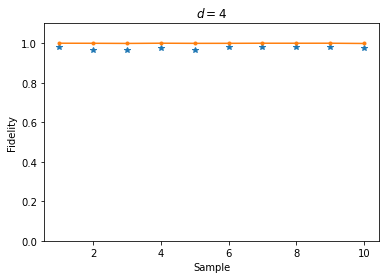

In [29]:
# Plotar a função de fidelidade SimXExpt para 2qubits
n_matrizes = range(1, n_matrices+1)
plt.plot(n_matrizes, fidelity_exp_4, '*', label=r'$F_{expt}$')
plt.plot(n_matrizes, fidelity_2, '.-', label=r'$F_{sim}$')
plt.xlabel('Sample')
plt.ylabel('Fidelity')
plt.title('$d=4$')
plt.ylim(0.0, 1.1)  # definir os limites do eixo vertical
plt.show()

In [37]:
#teste jakarta

# definir o número de matrizes a serem geradas
n_matrices = 2
fidelity_exp_ = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(4)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])

    # executar os circuitos de tomografia
    job_exp_ = qiskit.execute(qstc, backend = device, shots = nshots)
    print(job_exp_.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_exp_)

    # ajustar os dados
    qstf = StateTomographyFitter(job_exp_.result(), qstc)
    
    # extrair o operador densidade
    rho_exp_ = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rho_exp_)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rho_exp_)
    print("Fidelity: {}".format(fid))
    
    fidelity_exp_.append(fid)  # adicionar a fidelidade à lista de fidelidades


chqvreqnajhpa664ftc0
Job Status: job has successfully run
Density Operator 1:
[[ 0.20867176+0.j         -0.03335001-0.07209829j  0.06031215+0.01162558j
  -0.03633265-0.06085965j]
 [-0.03335001+0.07209829j  0.18721839+0.j         -0.0447061 -0.04480013j
  -0.02853139+0.03649579j]
 [ 0.06031215-0.01162558j -0.0447061 +0.04480013j  0.32654326+0.j
   0.12663681+0.03094889j]
 [-0.03633265+0.06085965j -0.02853139-0.03649579j  0.12663681-0.03094889j
   0.27756658+0.j        ]]
Fidelity: 0.990504032630437
chrv541vrup8980064rg
Job Status: job has successfully run
Density Operator 2:
[[ 0.28882451+0.j         -0.07354316-0.06228637j -0.03673363+0.04035856j
  -0.10305589+0.07038676j]
 [-0.07354316+0.06228637j  0.52277227+0.j          0.0346084 -0.06729538j
   0.02044267+0.04081999j]
 [-0.03673363-0.04035856j  0.0346084 +0.06729538j  0.05591116+0.j
   0.00377563+0.00535637j]
 [-0.10305589-0.07038676j  0.02044267-0.04081999j  0.00377563-0.00535637j
   0.13249205+0.j        ]]
Fidelity: 0.9826017561

In [ ]:
#exp jakarta 2 qubits

# definir o número de matrizes a serem geradas
n_matrices = 2
fidelity_exp_ = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(4)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])

    # executar os circuitos de tomografia
    job_exp_ = qiskit.execute(qstc, backend = device, shots = nshots)
    print(job_exp_.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_exp_)

    # ajustar os dados
    qstf = StateTomographyFitter(job_exp_.result(), qstc)
    
    # extrair o operador densidade
    rho_exp_ = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rho_exp_)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rho_exp_)
    print("Fidelity: {}".format(fid))
    
    fidelity_exp_.append(fid)  # adicionar a fidelidade à lista de fidelidades

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# definir o número de matrizes a serem geradas
n_matrices = 10
fidelity_3 = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(8)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1],qr[2]])

    # executar os circuitos de tomografia
    job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    print(job_sim.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_sim)

    # ajustar os dados
    qstf = StateTomographyFitter(job_sim.result(), qstc)
    
    # extrair o operador densidade
    rhoDCBA = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rhoDCBA)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rhoDCBA)
    print("Fidelity: {}".format(fid))
    
    fidelity_3.append(fid)  # adicionar a fidelidade à lista de fidelidades




7d585209-149c-4b97-b180-c22262e96412
Job Status: job has successfully run
Density Operator 1:
[[ 0.07668055+0.j          0.03067392-0.01302391j -0.03532752+0.04543691j
   0.0304004 +0.01387657j  0.01117608-0.01928038j  0.01354898+0.00948902j
  -0.00610056-0.01367142j  0.05848596+0.03678201j]
 [ 0.03067392+0.01302391j  0.10994825+0.j          0.03077077+0.01028895j
  -0.02546378+0.01077481j -0.01537704-0.02272067j  0.01941306+0.00439302j
  -0.00060829-0.01865478j  0.01645551+0.03065754j]
 [-0.03532752-0.04543691j  0.03077077-0.01028895j  0.16384986+0.j
  -0.04059283+0.01514411j -0.06617279+0.0113815j   0.00700229-0.01464881j
  -0.00833935-0.03788801j  0.00168784-0.02225409j]
 [ 0.0304004 -0.01387657j -0.02546378-0.01077481j -0.04059283-0.01514411j
   0.12294751+0.j          0.00256614-0.02155166j -0.02072771+0.01284758j
  -0.00777777-0.02270943j  0.05026402+0.00098601j]
 [ 0.01117608+0.01928038j -0.01537704+0.02272067j -0.06617279-0.0113815j
   0.00256614+0.02155166j  0.14035294+0.j    

8da034e4-0547-4eac-afb8-359d40fb6a40
Job Status: job has successfully run
Density Operator 6:
[[ 0.05855111+0.j         -0.00617793+0.01052178j -0.00312569-0.02750524j
  -0.0129292 +0.01360028j -0.01866253+0.02281385j -0.00352173-0.00780919j
   0.01047385-0.02318573j -0.02121934+0.0028047j ]
 [-0.00617793-0.01052178j  0.18111364+0.j         -0.03526493+0.02470218j
  -0.00404969+0.0423047j   0.03083216+0.01587386j  0.02728556+0.0112239j
  -0.014684  -0.09291442j  0.0074166 -0.0015373j ]
 [-0.00312569+0.02750524j -0.03526493-0.02470218j  0.10305869+0.j
   0.078083  -0.0051769j   0.01241824-0.0126476j  -0.00272168-0.01703174j
  -0.02425651+0.02290567j -0.01155045-0.03244568j]
 [-0.0129292 -0.01360028j -0.00404969-0.0423047j   0.078083  +0.0051769j
   0.19292569+0.j          0.00646234-0.01328313j -0.00890829-0.00184406j
  -0.03998005-0.03224859j  0.00143656+0.02056304j]
 [-0.01866253-0.02281385j  0.03083216-0.01587386j  0.01241824+0.0126476j
   0.00646234+0.01328313j  0.11213138+0.j      

In [65]:
# definir o número de matrizes a serem geradas
n_matrices = 2
fid_3_exp = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(8)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1],qr[2]])

    # executar os circuitos de tomografia
    
    #job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    job_exp = execute(qstc, backend = device, shots = nshots)
    
    print(job_exp.job_id())
    # aguardar a conclusão da execução
    
    #job_monitor(job_sim)
    job_monitor(job_exp)

    # ajustar os dados
    qstf = StateTomographyFitter(job_exp.result(), qstc)
    
    # extrair o operador densidade
    rhoDCBA_exp = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rhoDCBA_exp)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rhoDCBA_exp)
    print("Fidelity: {}".format(fid))
    
    fid_3_exp.append(fid)  # adicionar a fidelidade à lista de fidelidades

chmi1ak6f7i49rr5s0kg
Job Status: job is queued (None)

IBMQJobApiError: "'400 Client Error: Bad Request for url: https://api-qcon.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/Jobs/chmi1ak6f7i49rr5s0kg/status/v/1. Error in runtime client calling method getJob: Error executing GET https://runtime-us-east.quantum-computing.ibm.com/jobs/chmi1ak6f7i49rr5s0kg {No request body}, Error code: 2413.'"

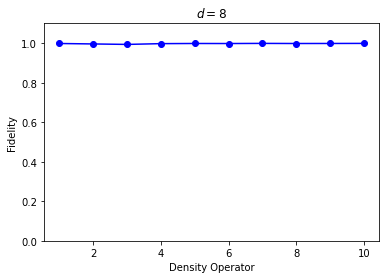

In [56]:
# Plotar a função de fidelidade
n_matrizes = range(1, n_matrices+1)
plt.plot(n_matrizes, fidelity_3, 'bo-')
plt.xlabel('Density Operator')
plt.ylabel('Fidelity')
plt.title('$d=8$')
plt.ylim(0.0, 1.1)  # definir os limites do eixo vertical
plt.show()

In [37]:

# definir o número de matrizes a serem geradas
n_matrices = 10
fidelity_2 = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(4)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])

    # executar os circuitos de tomografia
    job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    print(job_sim.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_sim)

    # ajustar os dados
    qstf = StateTomographyFitter(job_sim.result(), qstc)
    
    # extrair o operador densidade
    rhoDCBA = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rhoDCBA)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rhoDCBA)
    print("Fidelity: {}".format(fid))
    
    fidelity_2.append(fid)  # adicionar a fidelidade à lista de fidelidades

7e4a6026-92d1-42f0-83df-638bb8c17a23
Job Status: job has successfully run
Density Operator 1:
[[ 0.06312586+0.j          0.0536582 -0.00600979j  0.02993288+0.03917355j
  -0.0830011 +0.08917301j]
 [ 0.0536582 +0.00600979j  0.24410266+0.j         -0.00804161+0.0727238j
  -0.01193292+0.04889266j]
 [ 0.02993288-0.03917355j -0.00804161-0.0727238j   0.2088756 +0.j
  -0.09221118+0.13612628j]
 [-0.0830011 -0.08917301j -0.01193292-0.04889266j -0.09221118-0.13612628j
   0.48389588+0.j        ]]
Fidelity: 0.9994853206381324
686316cf-e94b-4d22-9a07-e41ea92b7c95
Job Status: job has successfully run
Density Operator 2:
[[ 0.17622247+0.j          0.05719403+0.20595502j -0.00498949+0.05693022j
  -0.00688868+0.0293511j ]
 [ 0.05719403-0.20595502j  0.55572903+0.j          0.08102984-0.01016503j
   0.07339828-0.0299852j ]
 [-0.00498949-0.05693022j  0.08102984+0.01016503j  0.15783993+0.j
   0.02168737-0.01612708j]
 [-0.00688868-0.0293511j   0.07339828+0.0299852j   0.02168737+0.01612708j
   0.11020857+0.j 

In [21]:
# definir o número de matrizes a serem geradas
n_matrices = 10
fidelity_2= []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(4)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])

    # executar os circuitos de tomografia
    
    job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    #job_exp = execute(qstc, backend = device, shots = nshots)
    
    print(job_sim.job_id())
    # aguardar a conclusão da execução
    
    job_monitor(job_sim)
    #job_monitor(job_exp)

    # ajustar os dados
    qstf = StateTomographyFitter(job_sim.result(), qstc)
    
    # extrair o operador densidade
    rhoDCBA_sim = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rhoDCBA_sim)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rhoDCBA_sim)
    print("Fidelity: {}".format(fid))
    
    fidelity_2.append(fid)  # adicionar a fidelidade à lista de fidelidades

bbac7309-4901-4648-99ba-d610143c9e1d
Job Status: job has successfully run
Density Operator 1:
[[ 0.10690635+0.j          0.03378326+0.02108871j  0.07498684-0.02155413j
  -0.06132656+0.04567859j]
 [ 0.03378326-0.02108871j  0.35106316+0.j         -0.01154531+0.02286037j
  -0.10306211+0.21337699j]
 [ 0.07498684+0.02155413j -0.01154531-0.02286037j  0.26271969+0.j
   0.01288612+0.05400296j]
 [-0.06132656-0.04567859j -0.10306211-0.21337699j  0.01288612-0.05400296j
   0.27931079+0.j        ]]
Fidelity: 0.9995594737884611
a264f386-2546-4fb1-84a9-3db8e3f62ec5
Job Status: job has successfully run
Density Operator 2:
[[0.27263352+0.j         0.02228118+0.01374863j 0.00104992-0.08226536j
  0.09539344+0.11544668j]
 [0.02228118-0.01374863j 0.11465126+0.j         0.12045718+0.05290786j
  0.10149298-0.05273953j]
 [0.00104992+0.08226536j 0.12045718-0.05290786j 0.27996342+0.j
  0.01196071-0.10466686j]
 [0.09539344-0.11544668j 0.10149298+0.05273953j 0.01196071+0.10466686j
  0.3327518 +0.j        ]]
Fidel

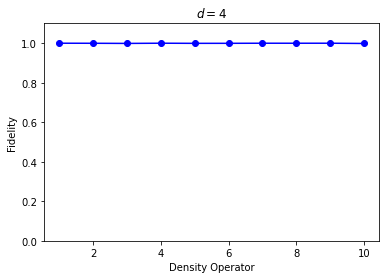

In [22]:
# Plotar a função de fidelidade
n_matrizes = range(1, n_matrices+1)
plt.plot(n_matrizes, fidelity_2, 'bo-')
plt.xlabel('Density Operator')
plt.ylabel('Fidelity')
plt.title('$d=4$')
plt.ylim(0.0, 1.1)  # definir os limites do eixo vertical
plt.show()

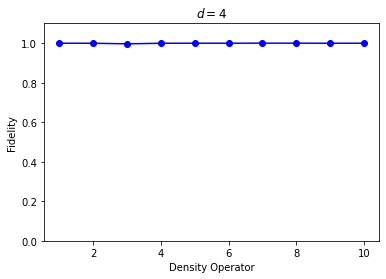

In [57]:
# Plotar a função de fidelidade
n_matrizes = range(1, n_matrices+1)
plt.plot(n_matrizes, fidelity_2, 'bo-')
plt.xlabel('Density Operator')
plt.ylabel('Fidelity')
plt.title('$d=4$')
plt.ylim(0.0, 1.1)  # definir os limites do eixo vertical
plt.show()

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# definir o número de matrizes a serem geradas
n_matrices = 10
fidelity_4 = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(16)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3],qr[4],qr[5],qr[6],qr[7]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1],qr[2],qr[3]])

    # executar os circuitos de tomografia
    job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    print(job_sim.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_sim)

    # ajustar os dados
    qstf = StateTomographyFitter(job_sim.result(), qstc)
    
    # extrair o operador densidade
    rhoDCBA = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rhoDCBA)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rhoDCBA)
    print("Fidelity: {}".format(fid))
    
    fidelity_4.append(fid)  # adicionar a fidelidade à lista de fidelidades
    

c24b1c26-853a-4a79-9d3e-2ae6ed5834dd
Job Status: job has successfully run
Density Operator 1:
[[ 7.30969976e-02+0.j         -2.57883257e-04-0.0032879j
   1.41068473e-02-0.00964707j  6.77704975e-03+0.00570272j
  -7.30595991e-03-0.01210861j  8.32444893e-03-0.02332295j
  -1.01514483e-02+0.00428225j -1.32047914e-02-0.017153j
   1.09884238e-02+0.01345388j -2.06001388e-02+0.01152055j
   4.05649272e-03-0.01393846j -1.79859172e-03-0.00890383j
   4.88821319e-03+0.00657903j -8.38249900e-03-0.0022949j
  -5.94127379e-03+0.00401118j  2.34016805e-04+0.00886496j]
 [-2.57883257e-04+0.0032879j   5.23369706e-02+0.j
  -5.59475824e-03-0.00037843j -3.65535597e-03+0.01215815j
   8.49837876e-03-0.01884705j -1.22878750e-02+0.00815504j
   5.83533711e-03+0.0138142j  -4.02976512e-03+0.02063934j
  -5.49505599e-03-0.00177213j  6.43095742e-03-0.02335715j
   1.11481276e-02-0.02777257j  3.36471256e-04-0.0083169j
   1.49706882e-02-0.00977361j  1.25146218e-03-0.01216786j
  -1.35745415e-02-0.00494586j -1.34658875e-02+0.

4d4a73cc-4989-40ba-85ee-ed16c620426a
Job Status: job has successfully run
Density Operator 3:
[[ 7.48598844e-02+0.j          6.06998527e-03-0.00993567j
   2.64862738e-02-0.03319916j -1.71903438e-02+0.01116089j
  -1.05732253e-02+0.0081615j   9.80052991e-03-0.00802106j
  -3.73310995e-03-0.0033334j  -3.66876898e-03+0.00680549j
  -2.57892435e-02-0.01270783j -7.11541100e-04+0.01753921j
  -1.13867664e-02-0.01899361j -3.44465583e-03-0.00524745j
   1.82240234e-03-0.01298061j -3.02906924e-02+0.00120025j
  -1.33145528e-02-0.00548542j  1.35763640e-04-0.00177858j]
 [ 6.06998527e-03+0.00993567j  7.43204536e-02+0.j
   1.69236072e-03-0.00870536j  5.84472536e-03+0.00587989j
  -1.89452825e-02+0.003625j    9.47087308e-03-0.00120065j
  -6.21618031e-03+0.0027033j   5.56321400e-03+0.00569477j
   2.11320368e-02+0.00353328j  8.95043323e-05-0.00121557j
   8.74677322e-03-0.00592417j -1.47557641e-02-0.0092987j
  -5.68330443e-04+0.00624988j  6.13361469e-03+0.00062918j
   8.51162837e-03-0.00885891j -3.50055459e-0

3b997785-a3b4-4e26-a03b-ac622d6cb409
Job Status: job has successfully run
Density Operator 5:
[[ 3.70649278e-02+0.00000000e+00j -4.44690255e-03+8.84185370e-03j
  -2.77798071e-02+2.44924223e-03j  2.79479538e-04-4.18708257e-04j
  -2.41282636e-03+4.53818388e-03j -1.12609466e-02-4.48775919e-03j
   6.43611573e-03+6.36726444e-03j  6.82980767e-03+1.24384276e-02j
  -3.87173630e-03+1.12653612e-02j -2.17572100e-03+9.89874119e-03j
  -4.51424508e-04-6.19081554e-03j  3.09500442e-03+1.57532110e-03j
  -4.36092818e-03-1.43316856e-04j -4.68005815e-04-4.95717600e-03j
  -1.14187876e-02-1.34637910e-02j -1.93535684e-03+9.77750928e-04j]
 [-4.44690255e-03-8.84185370e-03j  4.23109374e-02+0.00000000e+00j
   2.03115918e-02-4.96259506e-03j  5.35034886e-03+1.00497632e-02j
  -3.91043266e-03+7.25170721e-03j  9.40592837e-03+2.72899711e-03j
  -1.15560721e-02+9.08923518e-03j -3.18490559e-03-9.19646780e-03j
   1.26237155e-02-4.96537844e-03j -9.78888056e-03+2.45932057e-03j
   7.37482709e-03+3.88798048e-03j -4.30828272e-

1ef8d6ca-34c2-4f7c-88a8-4d368df4035a
Job Status: job has successfully run
Density Operator 6:
[[ 9.85051377e-02+0.j         -1.57926968e-02+0.00033832j
   6.22513638e-03-0.0143369j   1.23552662e-02-0.01036038j
  -2.57775581e-03+0.00406903j -1.25451663e-02+0.02001104j
  -1.62759772e-03+0.0036902j  -6.04518668e-05+0.01136414j
   1.19311531e-02-0.01092099j -3.70393543e-03+0.00874531j
   6.47519753e-03-0.0053639j  -1.66523142e-02+0.01158866j
  -1.16532914e-02+0.01065435j  2.11769728e-02+0.00334986j
  -2.84799965e-02-0.01697395j  1.07204892e-02-0.00352465j]
 [-1.57926968e-02-0.00033832j  4.99579466e-02+0.j
  -2.26231223e-03+0.02060537j -1.64027756e-03-0.0155304j
  -4.33888025e-03+0.00092944j  8.34173041e-03-0.00151826j
   2.67429515e-03-0.00431224j -7.52826796e-03+0.00986895j
  -1.49771852e-02+0.01386426j  6.33180598e-03+0.01333198j
  -1.19904940e-03+0.00687096j  8.39546107e-03-0.00026818j
   2.77813746e-03+0.01517999j -3.90113067e-05-0.00846042j
   1.52085032e-02-0.0006887j   2.11973213e-0

10d688a5-c5ca-4c64-bef1-4709ba1877b7
Job Status: job has successfully run
Density Operator 8:
[[ 5.86665358e-02+0.j         -5.92521010e-03+0.00161799j
  -9.85429502e-03+0.01356635j -4.41318732e-03-0.00352089j
   9.65953463e-03-0.00353509j -4.55861594e-03+0.00259743j
   4.66659681e-03-0.01172122j -1.89268603e-02-0.00748552j
  -1.41286335e-02+0.00955493j -5.73951896e-03+0.00499823j
  -6.18302647e-03+0.01313386j -7.27854208e-03+0.00081556j
   1.97943355e-02-0.01163321j -1.02164035e-02+0.00773354j
   4.10930883e-03-0.0082928j  -1.36223624e-02+0.00433935j]
 [-5.92521010e-03-0.00161799j  7.65563695e-02+0.j
   9.61583313e-03-0.02629883j  1.66692066e-02-0.00129458j
   1.89909171e-02+0.00432438j  5.79464727e-05+0.00941079j
  -1.13154586e-02-0.0170155j   9.01749110e-03-0.01227659j
   2.11884307e-03-0.00925911j  9.96174597e-03+0.01194562j
  -2.56246199e-03-0.0066659j  -8.60896999e-04+0.00876958j
  -8.91312985e-03-0.01531051j  2.75944075e-03-0.00361776j
  -1.21791929e-03+0.00473652j  8.22088642e-

befdb61e-67de-4683-ad9b-79d8c60c59a2
Job Status: job has successfully run
Density Operator 10:
[[ 0.07075202+0.j         -0.00652781-0.01170286j  0.01724198+0.00073682j
   0.01464418-0.00260794j  0.00043744-0.01719593j  0.0083821 +0.00867411j
   0.00686219+0.00909234j -0.01487965+0.0015039j  -0.0021458 -0.01113171j
  -0.00336169-0.00198637j -0.00488501+0.00367143j -0.00215442+0.00465809j
  -0.00081   +0.00102441j -0.01660793-0.00902865j -0.02246714+0.02170658j
   0.00375973-0.02094957j]
 [-0.00652781+0.01170286j  0.08918849+0.j         -0.00261105+0.02055474j
   0.00758195+0.02715573j -0.01002416+0.01308974j -0.02118794+0.00472105j
   0.00542086-0.00223885j  0.00939011-0.00537287j  0.0105841 +0.02027817j
   0.01098016-0.00409466j  0.0113021 -0.01370714j -0.00175068+0.00106991j
   0.00190722+0.0116516j   0.02114308+0.00218749j  0.00867117-0.01980746j
   0.00573879-0.00399273j]
 [ 0.01724198-0.00073682j -0.00261105-0.02055474j  0.05408153+0.j
  -0.00126108+0.00846511j -0.00481341-0.00551

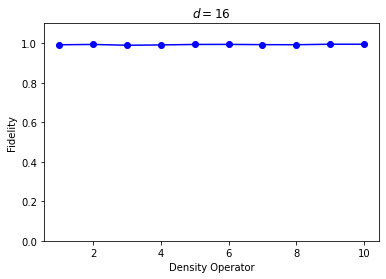

In [58]:
# Plotar a função de fidelidade
n_matrizes = range(1, n_matrices+1)
plt.plot(n_matrizes, fidelity_4, 'bo-')
plt.xlabel('Density Operator')
plt.ylabel('Fidelity')
plt.title('$d=16$')
plt.ylim(0.0, 1.1)  # definir os limites do eixo vertical
plt.show()

In [53]:
# definir o número de matrizes a serem geradas
n_matrices = 10
fidelity_5 = []  # lista para armazenar os valores de fidelidade
# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(32)
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3],qr[4],qr[5],qr[6],qr[7],qr[8],qr[9]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1],qr[2],qr[3],qr[4]])

    # executar os circuitos de tomografia
    job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    print(job_sim.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_sim)

    # ajustar os dados
    qstf = StateTomographyFitter(job_sim.result(), qstc)
    
    # extrair o operador densidade
    rhoDCBA = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rhoDCBA)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rhoDCBA)
    print("Fidelity: {}".format(fid))
    fidelity_5.append(fid)  # adicionar a fidelidade à lista de fidelidades

3a0de5ec-f454-41a8-ac29-5d9162366cfa
Job Status: job has successfully run
Density Operator 1:
[[ 0.03059962+0.j         -0.00185543+0.00031962j -0.00356519+0.00528343j
  ... -0.00035775-0.00175393j -0.00091815-0.00440393j
  -0.00710445-0.00238912j]
 [-0.00185543-0.00031962j  0.03009155+0.j         -0.0001254 +0.00076921j
  ... -0.00622092+0.00127185j -0.00756753+0.00499833j
   0.00039241+0.00115785j]
 [-0.00356519-0.00528343j -0.0001254 -0.00076921j  0.02574837+0.j
  ...  0.0033817 +0.00184731j -0.00138123+0.00222522j
  -0.00059989-0.00309559j]
 ...
 [-0.00035775+0.00175393j -0.00622092-0.00127185j  0.0033817 -0.00184731j
  ...  0.02188075+0.j         -0.00172496+0.00239591j
  -0.0009023 -0.00337637j]
 [-0.00091815+0.00440393j -0.00756753-0.00499833j -0.00138123-0.00222522j
  ... -0.00172496-0.00239591j  0.02707375+0.j
  -0.00076003-0.00342109j]
 [-0.00710445+0.00238912j  0.00039241-0.00115785j -0.00059989+0.00309559j
  ... -0.0009023 +0.00337637j -0.00076003+0.00342109j
   0.02973614+

6ea7bea7-ea14-440b-9c85-e4e5ccdf0820
Job Status: job has successfully run
Density Operator 9:
[[ 0.03246489+0.j          0.00231868+0.00411229j  0.00249507+0.00041097j
  ...  0.00232427+0.00498379j  0.00273832-0.00301986j
  -0.00064309-0.00084299j]
 [ 0.00231868-0.00411229j  0.03447207+0.j          0.00041706-0.00206305j
  ...  0.00355212+0.00398682j  0.00489232+0.00175845j
   0.00275897-0.00498418j]
 [ 0.00249507-0.00041097j  0.00041706+0.00206305j  0.03856884+0.j
  ...  0.0051613 +0.0006987j  -0.00302037-0.01169696j
  -0.00094331+0.00339063j]
 ...
 [ 0.00232427-0.00498379j  0.00355212-0.00398682j  0.0051613 -0.0006987j
  ...  0.03065779+0.j         -0.00269613-0.00055303j
  -0.00181348+0.00619285j]
 [ 0.00273832+0.00301986j  0.00489232-0.00175845j -0.00302037+0.01169696j
  ... -0.00269613+0.00055303j  0.03580406+0.j
  -0.00543406-0.00675367j]
 [-0.00064309+0.00084299j  0.00275897+0.00498418j -0.00094331-0.00339063j
  ... -0.00181348-0.00619285j -0.00543406+0.00675367j
   0.02677891+0

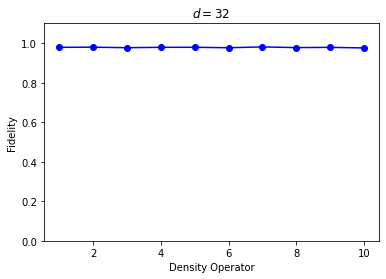

In [59]:
# Plotar a função de fidelidade
n_matrizes = range(1, n_matrices+1)
plt.plot(n_matrizes, fidelity_5, 'bo-')
plt.xlabel('Density Operator')
plt.ylabel('Fidelity')
plt.title('$d=32$')
plt.ylim(0.0, 1.1) 
plt.show()

In [21]:
plt.figure(figsize = (8,5), dpi = 100)
plt.plot(j, fid, '-.', label = r'$F_{sim}$'); 
#plt.plot(t, F_exp, '-.', label = r'$F_{exp}$')
plt.xlabel(r'$j$'); 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(); plt.show()

NameError: name 'j' is not defined

<Figure size 800x500 with 0 Axes>

In [18]:
display(rho)

array([[ 0.15235937+0.j        , -0.04212331+0.01207962j,
         0.02095647+0.0563636j ,  0.00745996-0.00164902j],
       [-0.04212331-0.01207962j,  0.34197114+0.j        ,
         0.01121735+0.11395111j,  0.10018567-0.23170779j],
       [ 0.02095647-0.0563636j ,  0.01121735-0.11395111j,
         0.11476767+0.j        , -0.11385952-0.02609953j],
       [ 0.00745996+0.00164902j,  0.10018567+0.23170779j,
        -0.11385952+0.02609953j,  0.39090181+0.j        ]])

In [23]:
def tomograph(qc, list_qr):
        print(list_qr)
        qstc = state_tomography_circuits(qc, [list_qr[0], list_qr[1]])
        #nshots = 8192
        job = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
        qstf = StateTomographyFitter(job.result(), qstc)
        rhoAB = qstf.fit(method='lstsq')
        return rhoAB

In [24]:
#    def qc_U():
        
#        U_op = Operator(u)
#        qc = QuantumCircuit(qubits, qubits, name = 'unitária')
#        for i in range(n):
#            qc.append(u, [i])
#        return qc


In [8]:
rho = rdm_ginibre(4)
psi, u = get_abs_lambda(rho)
qc = get_psi_circuit(psi, rho)
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
#qstc = state_tomography_circuits(qc, [qr[0],qr[1],qr[2],qr[3]]); # circuito para TEQ
job_sim = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots = nshots)
#job_exp = qiskit.execute(qstc, backend = device, shots = nshots)
print(job_sim.job_id()); job_monitor(job_sim)
#print(job_exp.job_id()); job_monitor(job_exp)
#qstf = StateTomographyFitter(job_exp.result(), qstc) # ajusta os dados
qstf = StateTomographyFitter(job_sim.result(), qstc)
rhoDCBA = qstf.fit(method='lstsq'); #rhoDCBA # extrai o operador densidade

IndentationError: unexpected indent (388617014.py, line 10)

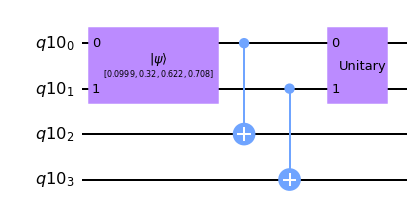

In [24]:
#from tools import *

rho = rdm_ginibre(4)
psi, u = get_abs_lambda(rho)
qc = get_rho_circuit(psi, rho, u)
qc.draw(output='mpl')

In [15]:
    for i in range(10):
        rho = rdm_ginibre(i)
    #    print(get_abs_lambda(rho))
    #rho = rdm_ginibre(4)
    print(rho)

[[ 0.11303407+0.j         -0.02113664+0.02028575j  0.02763009+0.02129975j
   0.01645315+0.02211982j -0.03328235-0.01467716j  0.05385154-0.00368715j
  -0.00336121-0.02970975j -0.01046997-0.03582283j  0.02111189+0.0161085j ]
 [-0.02113664-0.02028575j  0.09664294+0.j         -0.02835362+0.01488004j
  -0.02011479-0.03199527j -0.00294518+0.0417272j   0.03091026-0.01025446j
  -0.03724918+0.02143644j -0.01381291-0.00804274j -0.05221341-0.01032446j]
 [ 0.02763009-0.02129975j -0.02835362-0.01488004j  0.10761653+0.j
  -0.01115497+0.00169671j  0.01748798+0.01719876j -0.00027979+0.00580202j
  -0.05571111+0.00109402j -0.0055185 +0.02658389j  0.04268082+0.01951047j]
 [ 0.01645315-0.02211982j -0.02011479+0.03199527j -0.01115497-0.00169671j
   0.0646079 +0.j         -0.02570361-0.0065931j  -0.02178555-0.00809538j
  -0.00577637-0.03703643j  0.01170528+0.00041967j  0.01430549-0.01506293j]
 [-0.03328235+0.01467716j -0.00294518-0.0417272j   0.01748798-0.01719876j
  -0.02570361+0.0065931j   0.07503772+0.j 

In [39]:
# definir o número de matrizes a serem geradas
n_matrices = 10
fidelity_1= []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(2)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0]])

    # executar os circuitos de tomografia
    
    job_sim_1 = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    #job_exp = execute(qstc, backend = device, shots = nshots)
    
    print(job_sim_1.job_id())
    # aguardar a conclusão da execução
    
    job_monitor(job_sim_1)
    #job_monitor(job_exp)

    # ajustar os dados
    qstf = StateTomographyFitter(job_sim_1.result(), qstc)
    
    # extrair o operador densidade
    rhoDCBA_sim_1 = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rhoDCBA_sim_1)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rhoDCBA_sim_1)
    print("Fidelity: {}".format(fid))
    
    fidelity_1.append(fid)  # adicionar a fidelidade à lista de fidelidades

433de160-a6b6-4e1a-854e-ee25957626e6
Job Status: job has successfully run
Density Operator 1:
[[ 0.36364746+0.j         -0.37597656+0.24304199j]
 [-0.37597656-0.24304199j  0.63635254+0.j        ]]
Fidelity: 0.9999868762342087
75ef7230-ea19-4f9d-ac83-72b8936d60ae
Job Status: job has successfully run
Density Operator 2:
[[0.33325195+0.j        0.44152832+0.1541748j]
 [0.44152832-0.1541748j 0.66674805+0.j       ]]
Fidelity: 0.9999774174930856
eadbbb96-215d-47c6-aa96-35ed68e3f59f
Job Status: job has successfully run
Density Operator 3:
[[0.19897461+0.j         0.3034668 -0.17565918j]
 [0.3034668 +0.17565918j 0.80102539+0.j        ]]
Fidelity: 0.9999144776072146
e57139db-0dd9-463f-aec3-2fc0bbec9f44
Job Status: job has successfully run
Density Operator 4:
[[ 0.88781738+0.j         -0.08996582-0.23632813j]
 [-0.08996582+0.23632813j  0.11218262+0.j        ]]
Fidelity: 0.9999520918346682
b045dc12-855b-4071-ada9-7b4d64204394
Job Status: job has successfully run
Density Operator 5:
[[0.63500977+0

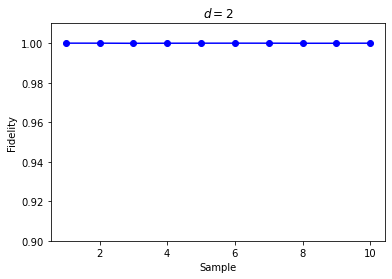

In [42]:
# Plotar a função de fidelidade
n_matrizes = range(1, n_matrices+1)
plt.plot(n_matrizes, fidelity_1, 'bo-')
plt.xlabel('Sample')
plt.ylabel('Fidelity')
plt.title('$d=2$')
plt.ylim(0.9, 1.01) 
plt.show()

In [46]:
#exp belem 1qubit

# definir o número de matrizes a serem geradas
n_matrices = 10
fidelity_exp_1 = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(2)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0]])

    # executar os circuitos de tomografia
    job_exp_1 = qiskit.execute(qstc, backend = device, shots = nshots)
    print(job_exp_1.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_exp_1)

    # ajustar os dados
    qstf = StateTomographyFitter(job_exp_1.result(), qstc)
    
    # extrair o operador densidade
    rho_exp_1 = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rho_exp_1)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rho_exp_1)
    print("Fidelity: {}".format(fid))
    
    fidelity_exp_1.append(fid)  # adicionar a fidelidade à lista de fidelidades


chsbhk3gsimdkukjmpgg
Job Status: job has successfully run
Density Operator 1:
[[0.59313965+0.j        0.37084961+0.0255127j]
 [0.37084961-0.0255127j 0.40686035+0.j       ]]
Fidelity: 0.9784063932823085
chsc23pvrup8980cjrr0
Job Status: job has successfully run
Density Operator 2:
[[ 0.63525391+0.j         -0.22631836+0.00158691j]
 [-0.22631836-0.00158691j  0.36474609+0.j        ]]
Fidelity: 0.9915132612181482
chsc2lorecnk2p3ffmc0
Job Status: job has successfully run
Density Operator 3:
[[0.52197266+0.j         0.34399414-0.20361328j]
 [0.34399414+0.20361328j 0.47802734+0.j        ]]
Fidelity: 0.9843882772735922
chsc3eb91dmpcnnjh3qg
Job Status: job has successfully run
Density Operator 4:
[[ 0.73400879+0.j         -0.09777832-0.25305176j]
 [-0.09777832+0.25305176j  0.26599121+0.j        ]]
Fidelity: 0.9945126620039046
chsc3ogrecnk2p3fghog
Job Status: job has successfully run
Density Operator 5:
[[0.31469727+0.j         0.22253418-0.18847656j]
 [0.22253418+0.18847656j 0.68530273+0.j      

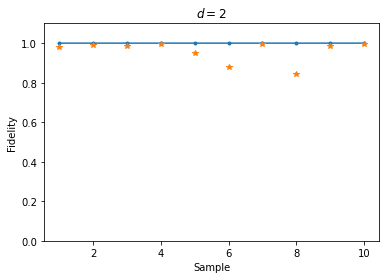

In [50]:
# Plotar a função de fidelidade
n_matrizes = range(1, n_matrices+1)
plt.plot(n_matrizes, fidelity_1, '.-', label=r'$F_{sim}$')
plt.plot(n_matrizes, fidelity_exp_1, '*', label=r'$F_{expt}$')
plt.xlabel('Sample')
plt.ylabel('Fidelity')
plt.title('$d=2$')
plt.ylim(0.0, 1.1) 
plt.show()



In [54]:
#exp lima 1qubit

# definir o número de matrizes a serem geradas
n_matrices = 10
fid_exp1 = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(2)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0]])

    # executar os circuitos de tomografia
    job_exp1 = qiskit.execute(qstc, backend = device, shots = nshots)
    print(job_exp1.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_exp1)

    # ajustar os dados
    qstf = StateTomographyFitter(job_exp1.result(), qstc)
    
    # extrair o operador densidade
    rho_exp1 = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rho_exp1)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rho_exp1)
    print("Fidelity: {}".format(fid))
    
    fid_exp1.append(fid)  # adicionar a fidelidade à lista de fidelidades

chscbk8recnk2p3fncig
Job Status: job has successfully run
Density Operator 1:
[[0.61853027+0.j         0.2454834 +0.11254883j]
 [0.2454834 -0.11254883j 0.38146973+0.j        ]]
Fidelity: 0.9969002877573051
chscliqi3durlgpqarv0
Job Status: job has successfully run
Density Operator 2:
[[ 0.40698242+0.j         -0.0612793 -0.18835449j]
 [-0.0612793 +0.18835449j  0.59301758+0.j        ]]
Fidelity: 0.9994041519999521
chsctnii3durlgpqhuag
Job Status: job has successfully run
Density Operator 3:
[[ 0.36730957+0.j         -0.12890625-0.12365723j]
 [-0.12890625+0.12365723j  0.63269043+0.j        ]]
Fidelity: 0.9972436913258419
chsd53pvrup8980dj270
Job Status: job has successfully run
Density Operator 4:
[[0.23095703+0.j         0.3260498 -0.06054687j]
 [0.3260498 +0.06054687j 0.76904297+0.j        ]]
Fidelity: 0.9714376394297126
chsdbpj91dmpcnnkkppg
Job Status: job has successfully run
Density Operator 5:
[[ 0.37524414+0.j         -0.04992676+0.24133301j]
 [-0.04992676-0.24133301j  0.62475586+0

In [69]:
#exp quito 1qubit

# definir o número de matrizes a serem geradas
n_matrices = 10
fid_exp1q = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(2)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0]])

    # executar os circuitos de tomografia
    job_exp1q = qiskit.execute(qstc, backend = device, shots = nshots)
    print(job_exp1q.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_exp1q)

    # ajustar os dados
    qstf = StateTomographyFitter(job_exp1q.result(), qstc)
    
    # extrair o operador densidade
    rho_exp1q = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rho_exp1q)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rho_exp1q)
    print("Fidelity: {}".format(fid))
    
    fid_exp1q.append(fid)  # adicionar a fidelidade à lista de fidelidades

chsfi8grecnk2p3ip1d0
Job Status: job has successfully run
Density Operator 1:
[[0.55639648+0.j         0.36950684+0.11779785j]
 [0.36950684-0.11779785j 0.44360352+0.j        ]]
Fidelity: 0.9922782628500426
chsfm58recnk2p3isbq0
Job Status: job has successfully run
Density Operator 2:
[[ 0.2923584 +0.j         -0.05175781-0.31311035j]
 [-0.05175781+0.31311035j  0.7076416 +0.j        ]]
Fidelity: 0.996268845995343
chsfur391dmpcnnn4940
Job Status: job has successfully run
Density Operator 3:
[[ 0.29724121+0.j         -0.19970703+0.20153809j]
 [-0.19970703-0.20153809j  0.70275879+0.j        ]]
Fidelity: 0.9843926206145959
chsg63391dmpcnnnb8q0
Job Status: job has successfully run
Density Operator 4:
[[0.66760254+0.j        0.43652344-0.0736084j]
 [0.43652344+0.0736084j 0.33239746+0.j       ]]
Fidelity: 0.9970884607484818
chsg9lai3durlgptnphg
Job Status: job has successfully run
Density Operator 5:
[[0.64221191+0.j         0.37036133+0.18200684j]
 [0.37036133-0.18200684j 0.35778809+0.j       

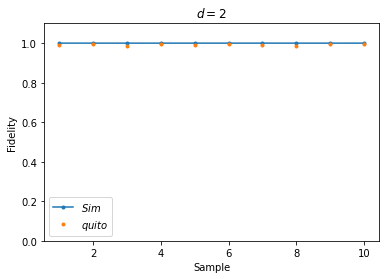

In [87]:
import matplotlib.pyplot as plt
# Plotar a função de fidelidade
n_matrizes = range(1, n_matrices+1)
plt.plot(n_matrizes, fidelity_1, '.-', label=r'$Sim$')
#plt.plot(n_matrizes, fid_exp1, '*', label=r'$Lima$')
#plt.plot(n_matrizes, fidelity_exp_1, 'o', label=r'$Belem$')
plt.plot(n_matrizes, fid_exp1q, '.', label=r'$quito$')
plt.xlabel('Sample')
plt.ylabel('Fidelity')
plt.title('$d=2$')
plt.ylim(0.0, 1.1)
plt.legend()
plt.show()

In [75]:
#exp quito 2qubit

# definir o número de matrizes a serem geradas
n_matrices = 10
fid_exp2q = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(4)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])

    # executar os circuitos de tomografia
    job_exp2q = qiskit.execute(qstc, backend = device, shots = nshots)
    print(job_exp2q.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_exp2q)

    # ajustar os dados
    qstf = StateTomographyFitter(job_exp2q.result(), qstc)
    
    # extrair o operador densidade
    rho_exp2q = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rho_exp2q)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rho_exp2q)
    print("Fidelity: {}".format(fid))
    
    fid_exp2q.append(fid)  # adicionar a fidelidade à lista de fidelidades

cht0nggrecnk2p41jrf0
Job Status: job has successfully run
Density Operator 1:
[[ 0.30991658+0.j         -0.03515856+0.13042079j -0.02543451+0.03317678j
   0.19059439-0.02728861j]
 [-0.03515856-0.13042079j  0.25278871+0.j         -0.0086178 +0.0301389j
  -0.07791002-0.07476891j]
 [-0.02543451-0.03317678j -0.0086178 -0.0301389j   0.1048456 +0.j
   0.01166762-0.04740707j]
 [ 0.19059439+0.02728861j -0.07791002+0.07476891j  0.01166762+0.04740707j
   0.33244912+0.j        ]]
Fidelity: 0.9736521656987593
cht4301oq2qn3r1ih40g
Job Status: job has successfully run
Density Operator 2:
[[ 0.22812967+0.j          0.15843858-0.04932818j -0.00809121-0.04363898j
  -0.05354969+0.01446103j]
 [ 0.15843858+0.04932818j  0.3318908 +0.j          0.06396072-0.00330834j
  -0.06444423+0.0219301j ]
 [-0.00809121+0.04363898j  0.06396072+0.00330834j  0.18470955+0.j
  -0.04650952+0.00984442j]
 [-0.05354969-0.01446103j -0.06444423-0.0219301j  -0.04650952-0.00984442j
   0.25526998+0.j        ]]
Fidelity: 0.9801930165

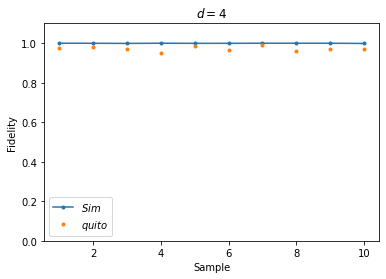

In [79]:
import matplotlib.pyplot as plt
# Plotar a função de fidelidade
n_matrizes = range(1, n_matrices+1)
#plt.plot(n_matrizes, fidelity_1, '.-', label=r'$Sim$')
#plt.plot(n_matrizes, fid_exp1, '*', label=r'$Lima$')
#plt.plot(n_matrizes, fidelity_exp_1, 'o', label=r'$Belem$')
plt.plot(n_matrizes, fidelity_2, '.-', label=r'$Sim$')
plt.plot(n_matrizes, fid_exp2q, '.', label=r'$quito$')
plt.xlabel('Sample')
plt.ylabel('Fidelity')
plt.title('$d=4$')
plt.ylim(0.0, 1.1)
plt.legend()
plt.savefig("F2qb_quito.pdf")
plt.show()

In [82]:
# expr Nairobi

# definir o número de matrizes a serem geradas
n_matrices = 10
fidelity_exp_3 = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(8)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1],qr[2]])

    # executar os circuitos de tomografia
    job_exp_3 = qiskit.execute(qstc, backend = device, shots = nshots)
    print(job_exp_3.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_exp_3)

    # ajustar os dados
    qstf = StateTomographyFitter(job_exp_3.result(), qstc)
    
    # extrair o operador densidade
    rho_exp_3 = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rho_exp_3)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rho_exp_3)
    print("Fidelity: {}".format(fid))
    
    fidelity_exp_3.append(fid)  # adicionar a fidelidade à lista de fidelidades


chv3k1e561q7nmcet1og
Job Status: job has successfully run
Density Operator 1:
[[ 1.48302606e-01+0.j         -7.50556381e-03+0.00313884j
  -1.28157833e-02+0.00254178j  5.70665803e-03-0.00090861j
  -3.35115437e-04+0.00296375j  8.06140919e-03-0.00929689j
  -7.07648766e-03+0.0036856j   6.78650363e-03+0.00319769j]
 [-7.50556381e-03-0.00313884j  1.30905198e-01+0.j
   1.40165552e-02-0.00359773j  3.52535798e-03+0.00320159j
   3.49947233e-03-0.01006387j -7.00768410e-03+0.00432373j
   9.68705693e-03+0.00112424j -7.41165122e-03+0.00044795j]
 [-1.28157833e-02-0.00254178j  1.40165552e-02+0.00359773j
   1.27482720e-01+0.j          2.18382035e-03+0.00104098j
  -3.70265643e-03-0.01014157j -7.58048219e-03+0.00092397j
   1.75133217e-02-0.01086448j -1.80726258e-04+0.00298485j]
 [ 5.70665803e-03+0.00090861j  3.52535798e-03-0.00320159j
   2.18382035e-03-0.00104098j  1.32682305e-01+0.j
   1.04532939e-02-0.00149284j  5.62362819e-03-0.00167725j
  -9.97067514e-03+0.01944493j  2.91973371e-03-0.00787071j]
 [-3.3

ci05vi93lqnvrkvb8ff0
Job Status: job has successfully run
Density Operator 6:
[[ 0.15837708+0.00000000e+00j  0.00209694-5.68768745e-03j
   0.00251444-1.81596028e-03j  0.0011667 -3.35777340e-03j
   0.01217007-4.04460827e-03j -0.00302331+3.52277322e-03j
  -0.00023896-7.46648910e-03j  0.00384862+1.01235373e-02j]
 [ 0.00209694+5.68768745e-03j  0.13656691+0.00000000e+00j
  -0.00471093-5.28488248e-03j -0.00094307-4.50123222e-03j
  -0.00572663+5.94473636e-03j -0.00311111+1.65740249e-03j
   0.00445914-2.14469598e-02j  0.01040237-3.44810891e-03j]
 [ 0.00251444+1.81596028e-03j -0.00471093+5.28488248e-03j
   0.11006923+0.00000000e+00j -0.00153411-1.08110237e-02j
   0.00062209+1.16109645e-03j  0.00375479+3.25710608e-03j
   0.0129608 -7.41288172e-05j  0.00402593+1.99957318e-03j]
 [ 0.0011667 +3.35777340e-03j -0.00094307+4.50123222e-03j
  -0.00153411+1.08110237e-02j  0.1245555 +0.00000000e+00j
   0.0012379 -7.37038579e-03j  0.00041454-2.82648228e-03j
   0.01029885-7.08140255e-03j  0.00146306-5.03499

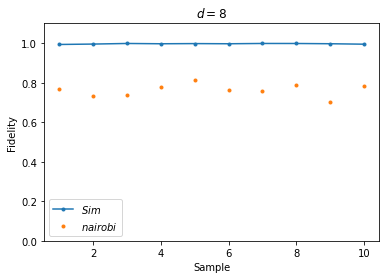

In [85]:
import matplotlib.pyplot as plt
# Plotar a função de fidelidade
n_matrizes = range(1, n_matrices+1)
#plt.plot(n_matrizes, fidelity_1, '.-', label=r'$Sim$')
#plt.plot(n_matrizes, fid_exp1, '*', label=r'$Lima$')
#plt.plot(n_matrizes, fidelity_exp_1, 'o', label=r'$Belem$')
plt.plot(n_matrizes, fidelity_3, '.-', label=r'$Sim$')
plt.plot(n_matrizes, fidelity_exp_3, '.', label=r'$nairobi$')
plt.xlabel('Sample')
plt.ylabel('Fidelity')
plt.title('$d=8$')
plt.ylim(0.0, 1.1)
plt.legend()
plt.savefig("F3qb_nairobi.pdf")
plt.show()

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# definir o número de matrizes a serem geradas
n_matrices = 10
fidelity_3 = []  # lista para armazenar os valores de fidelidade

# loop para gerar as matrizes
for i in range(n_matrices):
    # gerar entrada aleatória
    rho = rdm_ginibre(8)
    
    # definir o número de qubits
    n_qubits = int(np.ceil(np.log2(np.shape(rho)[0])))
    d = int(2*n_qubits)
    qr = QuantumRegister(d)
    
    # criar o circuito quântico
    qc = QuantumCircuit(qr)
    psi, u = get_abs_lambda(rho)
    qc_ = get_rho_circuit(psi, rho, u)
    qc.append(qc_,[qr[0],qr[1],qr[2],qr[3],qr[4],qr[5]])

    # obter os circuitos de tomografia
    qstc = state_tomography_circuits(qc, [qr[0],qr[1],qr[2]])

    # executar os circuitos de tomografia
    job_sim = execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    print(job_sim.job_id())
    # aguardar a conclusão da execução
    job_monitor(job_sim)

    # ajustar os dados
    qstf = StateTomographyFitter(job_sim.result(), qstc)
    
    # extrair o operador densidade
    rhoDCBA = qstf.fit(method='lstsq')
    print("Density Operator {}:".format(i+1))
    print(rhoDCBA)
    
    # calcular a fidelidade
    fid = state_fidelity(rho, rhoDCBA)
    print("Fidelity: {}".format(fid))
    
    fidelity_3.append(fid)  # adicionar a fidelidade à lista de fidelidades

f7a95764-309b-4392-a2cf-f40d3e40fdf5
Job Status: job has successfully run
Density Operator 1:
[[ 0.18445618+0.j         -0.03612652+0.01165108j -0.00728456-0.08306119j
   0.03921574+0.00740624j  0.00600498+0.07461202j  0.01944527-0.03195863j
  -0.03664232-0.00727048j  0.00780355-0.01632313j]
 [-0.03612652-0.01165108j  0.17946677+0.j          0.00944655-0.02557965j
   0.01095925-0.00735409j  0.02864086-0.00196881j  0.04631595+0.04223959j
   0.0217045 +0.02874344j -0.04921856-0.07763973j]
 [-0.00728456+0.08306119j  0.00944655+0.02557965j  0.11650014+0.j
   0.00037627+0.02282314j -0.04273285+0.04131242j  0.04311309+0.00374591j
  -0.04455892+0.00951275j  0.02317123-0.02601928j]
 [ 0.03921574-0.00740624j  0.01095925+0.00735409j  0.00037627-0.02282314j
   0.07990315+0.j         -0.03788427+0.04204275j  0.01098026+0.00621496j
  -0.02883891+0.02387563j -0.00072565-0.00350822j]
 [ 0.00600498-0.07461202j  0.02864086+0.00196881j -0.04273285-0.04131242j
  -0.03788427-0.04204275j  0.10605738+0.j   

ab9b9f75-11a9-47fe-b659-2f130e4ddc4e
Job Status: job has successfully run
Density Operator 6:
[[ 0.12743078+0.j         -0.03412559+0.0658309j   0.00628689-0.02404191j
  -0.02625759-0.06772855j -0.00547836-0.02710264j  0.03270035-0.00798694j
  -0.0026358 +0.02485249j  0.00536227-0.02127317j]
 [-0.03412559-0.0658309j   0.09558254+0.j         -0.00751815+0.03964629j
  -0.00833293+0.04396424j -0.01460105-0.0074093j  -0.00346559+0.00788653j
   0.03146464-0.01701762j -0.03086391-0.03994067j]
 [ 0.00628689+0.02404191j -0.00751815-0.03964629j  0.08857597+0.j
   0.01750485-0.01770733j  0.01238003+0.04660732j  0.02479792+0.01365676j
  -0.01769193-0.03238874j  0.00209126+0.03529104j]
 [-0.02625759+0.06772855j -0.00833293-0.04396424j  0.01750485+0.01770733j
   0.09758827+0.j         -0.02060438+0.01096033j -0.00673016+0.01456131j
  -0.01888309-0.01700286j -0.03432246+0.00726092j]
 [-0.00547836+0.02710264j -0.01460105+0.0074093j   0.01238003-0.04660732j
  -0.02060438-0.01096033j  0.18352167+0.j   

#  X-state Simulation

We show that the our preparation quantum algorithm it works for x-type two-qubit states

$$\rho_X = \begin{bmatrix} a&0&0&w \\ 0&b&z&0 \\ 0&z^*&c&0 \\ w^*&0&0&d \end{bmatrix},$$
with $d=1-a-b-c.$ Here we consider the real $X$ states:
$$w,z\in\mathbb{R}.$$

This density matrix can be diagonalized, resulting in 
$$\rho_X = \sum_{j,k=0}^{1}p_{jk}|\Psi_{jk}\rangle\langle\Psi_{jk}|,$$
with
\begin{align}
& |\Psi_{00}\rangle = \cos\theta|00\rangle+\sin\theta|11\rangle, \\
& |\Psi_{01}\rangle = \sin\phi|01\rangle+\cos\phi|10\rangle, \\
& |\Psi_{11}\rangle = \cos\phi|01\rangle-\sin\phi|10\rangle, \\
& |\Psi_{10}\rangle = -\sin\theta|00\rangle+\cos\theta|11\rangle.
\end{align}

In [15]:
from sympy import *
init_printing(use_unicode=True)
%matplotlib inline

In [101]:
p00,p01,p10,p11 = symbols('p_{00} p_{01} p_{10} p_{11}', positive=True, real=True)
th,ph = symbols('theta phi', positive=True, real=True)

def Psi00(th):
    return Matrix([[cos(th)],[0],[0],[sin(th)]]);

def Psi01(ph):
    return Matrix([[0],[sin(ph)],[cos(ph)],[0]]);

def Psi11(ph):
    return Matrix([[0],[cos(ph)],[-sin(ph)],[0]]);

def Psi10(th):
    return Matrix([[-sin(th)],[0],[0],[cos(th)]]);

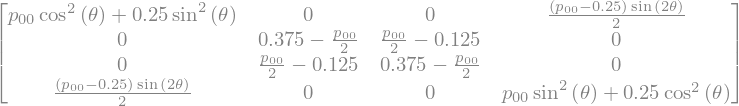

In [108]:

def rhoX(th,ph,p00,p01,p10,p11):
    return p00*(Psi00(th)*Psi00(th).T) +  p01*(Psi01(ph)*Psi01(ph).T) + p10*(Psi10(th)*Psi10(th).T) + p11*(Psi11(ph)*Psi11(ph).T)

simplify(rhoX(th,pi/4,p00,1/4,1/4,(1-2*p00)/2))

In [110]:
concurrence(rhoX(th,pi/4,0,1,0,0))

In [107]:
coh_l1(rhoX(pi/2,ph,0,1,0,0))

In [94]:
coh_l1(rhoX(th,pi/4,0,1,0,0))

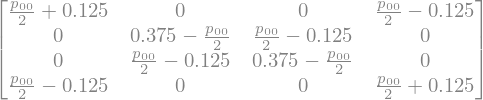

In [33]:
rhoX(pi/4,pi/4,p00,1/4,1/4,(1-2*p00)/2)

In [59]:
from sympy import *
import numpy as np

init_printing(use_unicode=True)
from matplotlib import pyplot as plt
%matplotlib inline
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum import TensorProduct
import scipy.interpolate
import platform


In [45]:
def cb(d, j):
    cbs = zeros(d,1); cbs[j] = 1
    return cbs


In [46]:
# Outside this function, initialize: evals = zeros(d,1)
def eVals(A):
    d = A.shape[0]; evals = zeros(d,1)
    eig = A.eigenvects()
    ne = 0
    j = 0
    lk = 0
    while ne < d:
        mult = eig[j][1]
        ne += mult
        nk = lk + mult
        for k in range(lk,nk):
            evals[k] = eig[j][0]
        lk = nk
        j += 1
    return evals

In [47]:
def mat_sqrt(A):
    d = A.shape[0]; eig = A.eigenvects(); Asqrt = zeros(d,d); ne = 0; j = 0; lk = 0
    while ne < d:
        mult = eig[j][1]; ne += mult
        for k in range(0,mult):
            Proj = proj(eig[j][2][k]); Asqrt += sqrt(eig[j][0])*(Proj/trace(Proj))
        j += 1
    return Asqrt
#mat_sqrt(pauli(3))

In [53]:
def Pauli(j):
    if j == 0:
        return Matrix([[1,0],[0,1]])
    elif j == 1:
        return Matrix([[0,1],[1,0]])
    elif j == 2:
        return Matrix([[0,-1j],[1j,0]])
    elif j == 3:
        return Matrix([[1,0],[0,-1]])

In [58]:
def Pauli_(j):
    if j == 0:
        return np.array([[1,0],[0,1]])
    elif j == 1:
        return np.array([[0,1],[1,0]])
    elif j == 2:
        return np.array([[0,-1j],[1j,0]])
    elif j == 3:
        return np.array([[1,0],[0,-1]])

In [49]:
def tp(x,y):
    return TensorProduct(x,y)

In [63]:
def tp_(x,y):
    return np.kron(x,y)

In [50]:
def coh_l1(rho):
    d = rho.shape[0]; C = 0
    for j in range(0,d-1):
        for k in range(j+1,d):
            C += abs(rho[j,k])
    return 2*C

In [65]:
def concurrence(rho):
    R = rho*tp(Pauli(2),Pauli(2))*conjugate(rho)*tp(Pauli(2),Pauli(2))
    evals = zeros(4,1)
    ev = eVals(R)
    evm = max(abs(ev[0]), abs(ev[1]), abs(ev[2]), abs(ev[3]))
    C = 2.0*sqrt(abs(evm)) - sqrt(abs(ev[0])) - sqrt(abs(ev[1])) - sqrt(abs(ev[2])) - sqrt(abs(ev[3]))
    if C < 0.0:
        C = 0.0
    return C

In [67]:
#conversão numpy
import numpy as np

def concurrence(rho):
    pauli = np.array([[0, 1], [1, 0]])
    tp_pauli = np.kron(pauli, pauli)
    rho_conj = np.conjugate(rho)
    
    R = rho.dot(tp_pauli).dot(rho_conj).dot(tp_pauli)
    ev = np.linalg.eigvals(R)
    evm = np.max(np.abs(ev))
    
    C = 2.0 * np.sqrt(np.abs(evm)) - np.sqrt(np.abs(ev[0])) - np.sqrt(np.abs(ev[1])) - np.sqrt(np.abs(ev[2])) - np.sqrt(np.abs(ev[3]))
    C = np.maximum(C, 0.0)
    
    return C


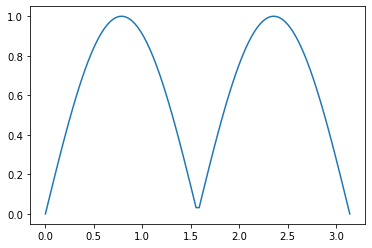

In [114]:
t = np.linspace(0,np.pi,100)
y = [concurrence(rhoX(np.pi/4,i,0,1,0,0)) for i in t]
plt.plot(t,y)
plt.show()

In [133]:
t = np.linspace(0,1.0,100)
y = [(rhoX(np.pi/4,i,0,1,0,0)) for i in t]
print(y)

[Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 0]]), Matrix([
[0,                    0,                  0, 0],
[0, 0.000102026935040062, 0.0101003230415957, 0],
[0,   0.0101003230415957,   0.99989797306496, 0],
[0,                    0,                  0, 0]]), Matrix([
[0,                    0,                 0, 0],
[0, 0.000408066102178355,  0.02019652406318, 0],
[0,     0.02019652406318, 0.999591933897822, 0],
[0,                    0,                 0, 0]]), Matrix([
[0,                    0,                  0, 0],
[0, 0.000917992604461977, 0.0302844827269698, 0],
[0,   0.0302844827269698,  0.999082007395538, 0],
[0,                    0,                  0, 0]]), Matrix([
[0,                   0,                  0, 0],
[0, 0.00163159833693843, 0.0403600820589519, 0],
[0,  0.0403600820589519,  0.998368401663062, 0],
[0,                   0,                  0, 0]]), Matrix([
[0,                   0,                  0, 0],
[0, 0.00254859207158488, 0.05041921012

In [ ]:
import numpy as np

# Defina o tamanho da matriz
n = 4
# Parâmetro 'x'
x = 0.5
# Crie uma matriz 4x4 preenchida com zeros
matriz = np.zeros((n, n))

# Loop para preencher a matriz com os coeficientes desejados
for i in range(n):
        coef = np.sin(x * i) + np.cos(x * j)
        matriz[i, j] = coef

# Imprima a matriz resultante
print(matriz)


In [38]:
coh_l1(rhoX(pi/4,pi/4,0,1/4,1/4,(1-2*0)/2))

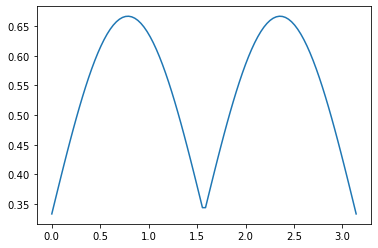

In [134]:
t = np.linspace(0,np.pi,100)
y = [coh_l1(rhoX(np.pi/4,i,2/3,1/3,1/3,0)) for i in t]
plt.plot(t,y)
plt.show()

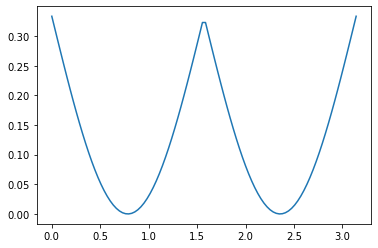

In [137]:
t = np.linspace(0,np.pi,100)
y = [concurrence(rhoX(np.pi/4,i,2/3,1/3,1/3,0)) for i in t]
plt.plot(t,y)
plt.show()

In [132]:
t = np.linspace(0,1.0,100)
#y = [concurrence(rhoX(np.pi/4,i,0,1,0,0)) for i in t]
for i in range(t)
    rho_xis[i] = np.array(rhoX(np.pi/4,i,2/3,1/3,1/3,0))
print(rho_xis[i])    

SyntaxError: invalid syntax (3735561763.py, line 3)

In [ ]:
# Número de pontos desejados
n = 10

# Criação da sequência de valores entre 0 e pi
parametros = np.linspace(0, np.pi, n)
# Criação da matriz 2x2 preenchida com zeros
matriz = np.zeros((n, n))

# Loop para preencher a matriz com base nos parâmetros
for i in range(n):
    for j in range(n):
        matriz[i, j] = np.sin(parametros[i]) + np.cos(parametros[j])

# Imprimir a matriz resultante
print(matriz)

In [22]:
import numpy as np

# Defina o tamanho da matriz
n = 4

# Parâmetro 'x'
x = 0.5

# Crie uma matriz 4x4 preenchida com zeros
matriz = np.zeros((n, n))

# Loop para preencher a matriz com os coeficientes desejados
for i in range(n):
    for j in range(n):
        coef = np.sin(x * i) + np.cos(x * j)
        matriz[i] = np.array([[1, 2], [3, 4]])

# Imprima a matriz resultante
print(matriz)


[[1.         0.87758256 0.54030231 0.0707372 ]
 [1.47942554 1.3570081  1.01972784 0.55016274]
 [1.84147098 1.71905355 1.38177329 0.91220819]
 [1.99749499 1.87507755 1.53779729 1.06823219]]
